In [1]:
import warnings
warnings.filterwarnings('ignore')

#import dependancies 
import pickle
import pandas as pd
from rdkit import Chem
import torch
from os import path
import matplotlib.pyplot as plt

#import pkasolver
import pkasolver
from pkasolver.query import QueryModel
from pkasolver.ml_architecture import GINPairV1
from pkasolver.query import draw_pka_map 
from pkasolver.query import calculate_microstate_pka_values, draw_pka_reactions
from IPython.display import display
from IPython.display import HTML

#load trained model
base_path=path.dirname(pkasolver.__file__)
##from pKaFunctions import RunPkasolver
#from ipynb.fs.full.pKaFunctions import *

#import MolGpKa
from predict_pka import *
from protonate import *

#import vizualizing modules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import rdkit

## Functions

In [2]:
def RunPkasolver(x):#takes input of smile object
    mol=Chem.MolFromSmiles(x)
    protonation_states = calculate_microstate_pka_values(mol) #performs internal calculations and stores as object
    sites=len(protonation_states) #get the number of ionization sites 
    
    lst=[]
    depSmi=[]
    proSmi=[]
    idx=[]
    for j in range(len(protonation_states)):
        state=protonation_states[j]
        depSmi.append(Chem.MolToSmiles(state.deprotonated_mol))
        proSmi.append(Chem.MolToSmiles(state.protonated_mol))
        idx.append(state.reaction_center_idx)
        lst.append(round(state.pka,2)) #get pka values for all sites for a given molecule store in a list
    yield sites,lst,proSmi,depSmi,idx

In [3]:
def RunMolGpKa(x):
    mol = Chem.MolFromSmiles(x)
    base_dict, acid_dict, m = predict(mol)
    smi=Chem.MolToSmiles(Chem.MolFromSmiles(Chem.MolToSmiles(m))) #ammended to return smile string to be used as input for chem axon
    atom_idx = list(base_dict.keys()) + list(acid_dict.keys())
    pkas = list(base_dict.values()) + list(acid_dict.values())
    sites=len(pkas)
    yield sites, pkas, atom_idx,smi

#### To generate chem axon calculation
in command line:
>> cxcalc pka -i 1 -x 14 .\ComparisonTableEx.txt > .\ComparisonTableEx_CaResults.txt

Where flag -i represents minimum pH and flag -x represents maximum pH

File 'ComparisonTableEx.txt' contain the smile string from RunMolGpKa() 


#### Difference in Indexing

Importantly, Chem axon uses a 1-start indexing where as pKaSolver and MolGpKa use a 0-start indexing

Therefore all atoms from Chem axon need to be -1 in order to match the 0-start indexing


In [9]:
def OneToZeroStart(atomList):
    atoms=[]
    if len(atomList)== 1:
        new=(atomList[0] -1)
        atoms.append(new)
    else:
        for i in atomList:
            new=(i-1)
            atoms.append(new)
    return(atoms)

In [10]:
#this part will be different for Nick,
##the import think here is to change the atom index to a Zero start
##Smiles MUST be the one MolGpKa output to ensure smiles numbering is the same

def GetChemAxon(file):
    #format chem axon output file into table
    axon=pd.read_table(file)
    axon['atoms']=axon['atoms'].astype(str)
    temp=axon['atoms'].str.split(',',expand=True).astype(int)
    idx=temp.values.flatten().tolist()
    
    #convert atom index to 0 start
    new_idx=OneToZeroStart(idx)
    
    ##extract pka values
    #isolate columns with only pka values
    axon=axon.iloc[:,1:-1]
    
    #remove empty columns
    axon.dropna(axis=1,inplace=True)
    
    #store pka values in a list
    pka=list(axon.loc[0])
    
    #make a dictionary with pka as key and atom index as value
    ca_dict=dict(zip(pka,new_idx))
    return ca_dict

In [11]:
#draws molecule, highlights and lables pKa sites that match the table
def DrawDiagram(std_smi,atom_idx):
    mol=Chem.MolFromSmiles(std_smi)
    cp=Chem.Mol(mol)

    for i in atom_idx:
        label= "atom#_" + str(i) 
        cp.GetAtomWithIdx(i).SetProp("atomNote",label)

    d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
    d2d.drawOptions().setHighlightColour((0.8,0.8,0.8))
    d2d.DrawMolecule(cp,highlightAtoms=solver_idx)
    d2d.FinishDrawing()
    return d2d

In [12]:
#merge columns with same names together
def MergeValues(x):
    return ', '.join(x[x.notnull()].astype(str))

In [13]:
#makes dataframes from pka/atom index dictionaries
def DictToDF(pka_dict):
    #make a dataframe from dictionary-- will result in multiple columns for same atoms (i.e atom_idx=[0,0,5] there will be three columns
    df=pd.DataFrame([pka_dict.keys()],columns=pka_dict.values()).add_prefix('atom#_')

    #group columns with the same name (in this case, atom index) and merge the values of those columns using function MergeValues
    df=df.groupby(level=0,axis=1).apply(lambda x:x.apply(MergeValues,axis=1))

    return df

In [14]:
#round pka values from MolGpKa, convert to float first because they are stored as a string from groupby
def RoundMolg(df):
    for c in df:
        for i in df.index:
            tmp=df[c][i].split(', ')
            if tmp != ['']:
                new=[]
                for l in tmp:
                    n=round(float(l),2)
                    n=str(n)
                    n.replace("[","")
                    new.append(n)
                df[c][i]=str(new).replace('[','').replace(']','').replace("'","")
            else:
                df[c][i]=tmp
    return df

## Demo
### Example 1

In [15]:
parent="CN(C)CCCN1C2=CC=CC=C2SC2=C1C=C(C=C2)C(C)=O"

#get pka from calculators
molg=RunMolGpKa(parent)
solver=RunPkasolver(parent)

In [16]:
#extract values from pkasolver output
for n,p,ds,ps,i in solver:
    solver_pka=p
    solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx)) #make dictionary with atom index and pkas

#extract values from molgpka output
for s,p,i,smiles in molg:
    molg_pka=p
    molg_smi=smiles
    molg_idx=i
molg_dict=dict(zip(molg_pka,molg_idx))#make dictionary with atom index and pkas
print(molg_smi) #uses as input for chem axon

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC(=O)c1ccc2c(c1)N(CCC[NH+](C)C)c1ccccc1S2
CC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2


In [17]:
#format chem axon output 
ca_dict=GetChemAxon('E1_output.txt')

#chem Axon dataframe
ca_df=DictToDF(ca_dict)

#pkasolver dataframe
solver_df=DictToDF(solver_dict)

#MolGpKa -- addional formatting because MolGpKa does not round pka values
molg_df=DictToDF(molg_dict)
RoundMolg(molg_df)

#combine all dataframes
all=pd.concat([solver_df,molg_df,ca_df],ignore_index=True)
all.insert(0,'Calculator',['pKaSolver','MolGpKa','Chem Axon'])
all

,Calculator,atom#_13,atom#_9
0,pKaSolver,8.71,4.2
1,MolGpKa,9.48,5.57
2,Chem Axon,8.5,NaN


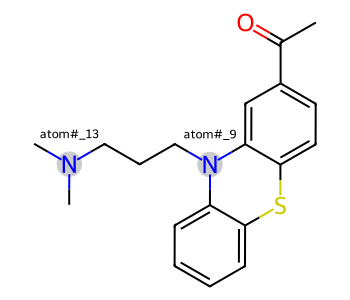

In [18]:
pic=DrawDiagram(molg_smi,molg_idx)
SVG(pic.GetDrawingText())

### Example 2

In [19]:
parent_2='O=C(O)CC(O)(CC(=O)O)C(=O)O'
molg=RunMolGpKa(parent_2)
solver=RunPkasolver(parent_2)

In [20]:
#extract values from pkasolver output
for n,p,ds,ps,i in solver:
    solver_pka=p
    solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx)) #make dictionary with atom index and pkas

#extract values from molgpka output
for s,p,i,smiles in molg:
    molg_pka=p
    molg_smi=smiles
    molg_idx=i
molg_dict=dict(zip(molg_pka,molg_idx))#make dictionary with atom index and pkas
print(molg_smi) #uses as input for chem axon

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-]
O=C(O)CC(O)(CC(=O)O)C(=O)O


In [21]:
ca_dict=GetChemAxon('E2_output.txt')

In [22]:

#chem Axon dataframe
ca_df=DictToDF(ca_dict)

#pkasolver dataframe
solver_df=DictToDF(solver_dict)

#MolGpKa -- addional formatting because MolGpKa does not round pka values
molg_df=DictToDF(molg_dict)
RoundMolg(molg_df)

#combine all dataframes
all=pd.concat([solver_df,molg_df,ca_df],ignore_index=True)
all.insert(0,'Calculator',['pKaSolver','MolGpKa','Chem Axon'])
all

,Calculator,atom#_12,atom#_2,atom#_5,atom#_9
0,pKaSolver,3.98,2.95,7.49,3.43
1,MolGpKa,7.72,7.41,10.92,7.41
2,Chem Axon,3.05,4.67,NaN,NaN


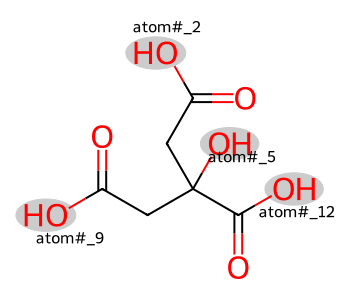

In [23]:
pic=DrawDiagram(molg_smi,molg_idx)
SVG(pic.GetDrawingText())

### Example 3

In [24]:
parent_3='CC(O)=O'
molg=RunMolGpKa(parent_3)
solver=RunPkasolver(parent_3)

In [25]:
## Make dictionaries for pka and atom indices for each calculator
#extract values from pkasolver output
for n,p,ds,ps,i in solver:
    solver_pka=p
    solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx)) #make dictionary with atom index and pkas

#extract values from molgpka output
for s,p,i,smiles in molg:
    molg_pka=p
    molg_smi=smiles
    molg_idx=i
molg_dict=dict(zip(molg_pka,molg_idx))#make dictionary with atom index and pkas
print(molg_smi) #uses as input for chem axon

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC(=O)[O-]
CC(=O)O


In [26]:
#format chem axon output 
ca_dict=GetChemAxon('E3_output.txt')

#chem Axon dataframe
ca_df=DictToDF(ca_dict)

#pkasolver dataframe
solver_df=DictToDF(solver_dict)

#MolGpKa -- addional formatting because MolGpKa does not round pka values
molg_df=DictToDF(molg_dict)
RoundMolg(molg_df)

#combine all dataframes
all=pd.concat([solver_df,molg_df,ca_df],ignore_index=True)
all.insert(0,'Calculator',['pKaSolver','MolGpKa','Chem Axon'])
all

,Calculator,atom#_3
0,pKaSolver,4.19
1,MolGpKa,8.34
2,Chem Axon,4.54


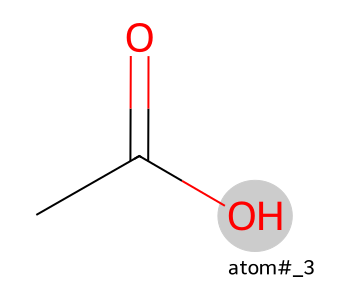

In [27]:
pic=DrawDiagram(molg_smi,molg_idx)
SVG(pic.GetDrawingText())

### Example 4

In [28]:
parent_4='C(O)1=CC=C(N)C=C1'
molg=RunMolGpKa(parent_4)
solver=RunPkasolver(parent_4)

In [29]:
## Make dictionaries for pka and atom indices for each calculator
#extract values from pkasolver output
for n,p,ds,ps,i in solver:
    solver_pka=p
    solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx)) #make dictionary with atom index and pkas

#extract values from molgpka output
for s,p,i,smiles in molg:
    molg_pka=p
    molg_smi=smiles
    molg_idx=i
molg_dict=dict(zip(molg_pka,molg_idx))#make dictionary with atom index and pkas
print(molg_smi) #uses as input for chem axon

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Nc1ccc(O)cc1
Nc1ccc(O)cc1


In [30]:
#read in an format chem axon data
ca_dict=GetChemAxon('E4_output.txt')

#chem Axon dataframe
ca_df=DictToDF(ca_dict)

#pkasolver dataframe
solver_df=DictToDF(solver_dict)

#MolGpKa -- addional formatting because MolGpKa does not round pka values
molg_df=DictToDF(molg_dict)
RoundMolg(molg_df)

#combine all dataframes
all=pd.concat([solver_df,molg_df,ca_df],ignore_index=True)
all.insert(0,'Calculator',['pKaSolver','MolGpKa','Chem Axon'])
all

,Calculator,atom#_0,atom#_5
0,pKaSolver,"6.61, 10.43",10.94
1,MolGpKa,"5.07, 14.12",12.19
2,Chem Axon,5.43,10.4


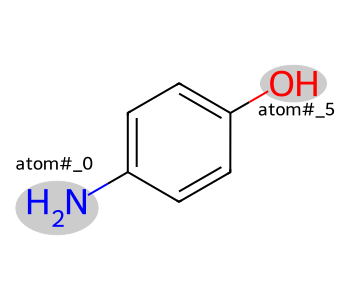

In [31]:
pic=DrawDiagram(molg_smi,molg_idx)
SVG(pic.GetDrawingText())